# Machine Learning On Features

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os

print(os.getcwd())
repo_root = os.path.dirname(os.getcwd())
print(repo_root)
src_path = os.path.join(repo_root, 'src')
print(src_path)
os.sys.path.append(src_path)
if src_path not in os.sys.path:
    os.sys.path.append(src_path)

import features as ft

c:\Users\leona\OneDrive\Documents\Alpha Factor Research\ml-alpha-factor-research\notebooks
c:\Users\leona\OneDrive\Documents\Alpha Factor Research\ml-alpha-factor-research
c:\Users\leona\OneDrive\Documents\Alpha Factor Research\ml-alpha-factor-research\src


Again we load the data for the GOOGL ticker

In [24]:
def fetch_stock_data(ticker, start_date, end_date):
    # Fetch stock data
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.DateOffset(years=15)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

print(end_date, start_date)

df_googl = fetch_stock_data('GOOGL', start_date, end_date)
print(df_googl.head())

2025-08-13 00:00:00 2010-08-13 00:00:00


C:\Users\leona\AppData\Local\Temp\ipykernel_13992\3332442458.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker          GOOGL      GOOGL      GOOGL      GOOGL      GOOGL
Date                                                             
2010-08-13  12.098363  12.218761  12.089904  12.164283   77310612
2010-08-16  12.079457  12.185926  11.952839  12.031944   52147800
2010-08-17  12.202095  12.306076  12.090403  12.152592   75552372
2010-08-18  11.993885  12.210802  11.978960  12.200106  107348544
2010-08-19  11.641146  12.002840  11.623234  11.965526  156843000


In [66]:
df_features = pd.DataFrame(index=df_googl.index)
close_price = df_googl['Close']
volume = df_googl['Volume']

df_features['mom_5'] = ft.momentum(close_price, 5)
df_features['mom_10'] = ft.momentum(close_price, 10)
df_features['mom_15'] = ft.momentum(close_price, 15)


df_features['volat_5'] = ft.roll_volatility(close_price, 5)
df_features['volat_10'] = ft.roll_volatility(close_price, 10)
df_features['volat_15'] = ft.roll_volatility(close_price, 15)

df_features['ma_ratio_5'] = ft.MA_ratio(close_price, 5)
df_features['ma_ratio_10'] = ft.MA_ratio(close_price, 10)
df_features['ma_ratio_15'] = ft.MA_ratio(close_price, 15)

df_features['z_score_5'] = ft.z_score(close_price, 5)
df_features['z_score_10'] = ft.z_score(close_price, 10)
df_features['z_score_15'] = ft.z_score(close_price, 15)

df_features['vol_z_score_5'] = ft.z_score(volume, 5)
df_features['vol_z_score_10'] = ft.z_score(volume, 10)
df_features['vol_z_score_15'] = ft.z_score(volume, 15)

df_features['RSI_5'] = ft.RSI(close_price, 5)
df_features['RSI_10'] = ft.RSI(close_price, 10)
df_features['RSI_15'] = ft.RSI(close_price, 15)

df_features['vol_spike_5'] = ft.vol_spike(volume, 5)
df_features['vol_spike_10'] = ft.vol_spike(volume, 10)
df_features['vol_spike_15'] = ft.vol_spike(volume, 15)

df_features['vol_mom_5'] = ft.momentum(volume, 5)
df_features['vol_mom_10'] = ft.momentum(volume, 10)
df_features['vol_mom_15'] = ft.momentum(volume, 15)

df_features.dropna(inplace=True)
print(df_features.head())




               mom_5    mom_10    mom_15   volat_5  volat_10  volat_15  \
Date                                                                     
2010-09-03  0.024998  0.017921 -0.033001  0.014886  0.015500  0.015933   
2010-09-07  0.025868  0.000711 -0.043638  0.014630  0.016108  0.016157   
2010-09-08  0.045687  0.042513 -0.040651  0.013460  0.013272  0.016357   
2010-09-09  0.034432  0.047424 -0.012382  0.011363  0.013471  0.016242   
2010-09-10  0.027980  0.055790  0.017458  0.011791  0.012858  0.014173   

            ma_ratio_5  ma_ratio_10  ma_ratio_15  z_score_5  ...  \
Date                                                         ...   
2010-09-03    1.023941     1.027661     1.012899   1.346076  ...   
2010-09-07    1.005966     1.014696     1.003245   0.369902  ...   
2010-09-08    1.010353     1.023906     1.019523   1.066069  ...   
2010-09-09    1.015465     1.031253     1.032546   1.378241  ...   
2010-09-10    1.009798     1.025578     1.031241   0.942435  ...   

    

We now need to prepare our target data. We have a classification problem, so our data should be a binary dataset. We will set a forecasting horizon of $K$ days. A 1 will represent if $P_{t+K} > P_{t}$ and a 0 will represent $P_{t+K} \le P_{t}$.

In [67]:
def make_classification_target(close: pd.Series, horizon: int) -> pd.DataFrame:
    """
    Create forward return and binary classification target from a price series.

    Parameters
    ----------
    close : pd.Series
        Series of closing prices, indexed by date.
    horizon : int, default 5
        Forecast horizon in days (e.g., 1 = next day, 5 = next week).

    Returns
    -------
    target_df : pd.DataFrame
        DataFrame with:
            'futret_<horizon>' : forward return over the horizon
            'target'           : binary label (1 if up, 0 if down or flat)
    """
    # Forward return
    futret = close.shift(-horizon) / close - 1
    futret_name = f"futret_{horizon}"

    # Binary target: 1 if forward return > 0, else 0
    target = (futret > 0).astype(int)

    # Combine into DataFrame
    target_df = pd.DataFrame({
        futret_name: futret,
        "target": target
    }, index=close.index)

    # Drop last horizon rows with NaNs in forward return
    target_df = target_df.dropna(subset=["target"])

    return target_df


In [76]:
ser_close = close_price['GOOGL']
df_ret = make_classification_target(ser_close, horizon=1)
ret_adj = df_ret[15:]
print(df_features.tail())
print(df_features.tail())

df_features.dropna(inplace=True)
print(df_features.tail())
#df_features.drop(columns=['futret_1'], inplace=True)
print(df_features.tail())


               mom_5    mom_10    mom_15   volat_5  volat_10  volat_15  \
Date                                                                     
2025-08-05 -0.005517  0.017404  0.069615  0.020946  0.015533  0.014087   
2025-08-06 -0.002239  0.030805  0.071706  0.021191  0.015369  0.014103   
2025-08-07  0.024075  0.022636  0.070487  0.016788  0.015168  0.014114   
2025-08-08  0.064982  0.042655  0.088404  0.014546  0.016779  0.015048   
2025-08-11  0.030558  0.043722  0.057338  0.011207  0.016732  0.013922   

            ma_ratio_5  ma_ratio_10  ma_ratio_15  z_score_5  ...      RSI_5  \
Date                                                         ...              
2025-08-05    1.006286     1.008037     1.019489   0.413646  ...  46.265548   
2025-08-06    1.014087     1.012318     1.022243   0.962844  ...  48.543036   
2025-08-07    1.011478     1.012264     1.019898   0.748074  ...  71.192750   
2025-08-08    1.023746     1.033119     1.039444   1.718975  ...  97.160433   
2025-08

The baseline model to test other models agaianst will be a logistic regression model which we will now implement

In [87]:
X = df_features.iloc[:, :-1] # All columns except the last one
y = df_features.iloc[:, -1] # Last column as target

n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [95]:
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred_val = pipe.predict(X_val)
y_pred_val_prob = pipe.predict_proba(X_val)[:,1]
y_pred_val_bin = (y_pred_val_prob > 0.5).astype(int)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_bin))
print("Validation ROC AUC:", roc_auc_score(y_val, y_pred_val_prob))

Validation Accuracy: 0.5352862849533955
Validation ROC AUC: 0.5038981474858737


           feature  importance       std
13  vol_z_score_10    0.045051  0.009810
15           RSI_5    0.032756  0.009287
10      z_score_10    0.023968  0.009976
8      ma_ratio_15    0.023657  0.012936
17          RSI_15    0.022503  0.013259
4         volat_10    0.021660  0.012864
22      vol_mom_10    0.020728  0.007315
11      z_score_15    0.019751  0.009639
9        z_score_5    0.015313  0.012485
1           mom_10    0.014336  0.010578


<BarContainer object of 24 artists>

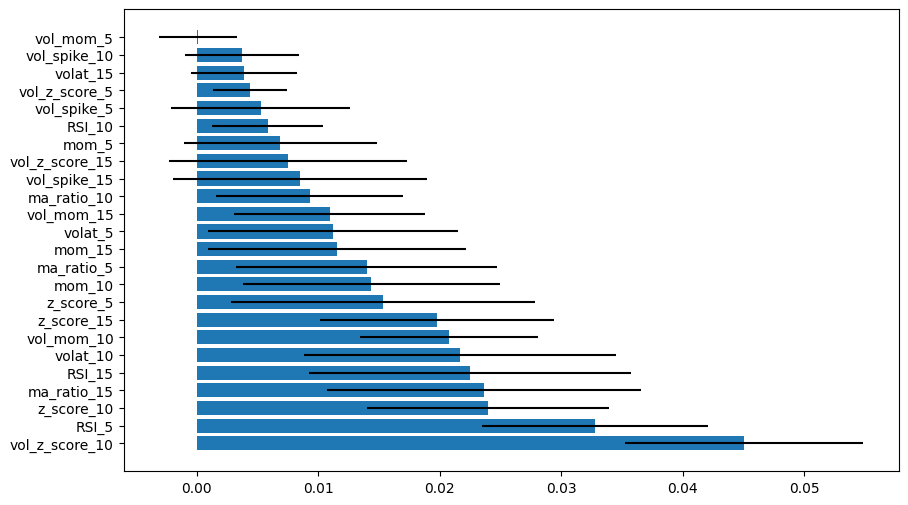

In [97]:
from sklearn.inspection import permutation_importance
result = permutation_importance(pipe, X_val, y_val, n_repeats=30, random_state=42)

perm_df =  pd.DataFrame({
    'feature': X_val.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
}).sort_values(by='importance', ascending=False)

print(perm_df.head(10))
plt.figure(figsize=(10, 6))
plt.barh(perm_df['feature'], perm_df['importance'], xerr=perm_df['std'])

The permutation importance measures the accruacy drop when rnadomly shiffling a feature. This breaks the time order of the feature so that it becomes redundant. This is done multiple times for each feature to gain an anvergae and a standard deviation on the accuracy drop.

Before dropping the weekest features however, a correlation check needs to be conducted between the features.

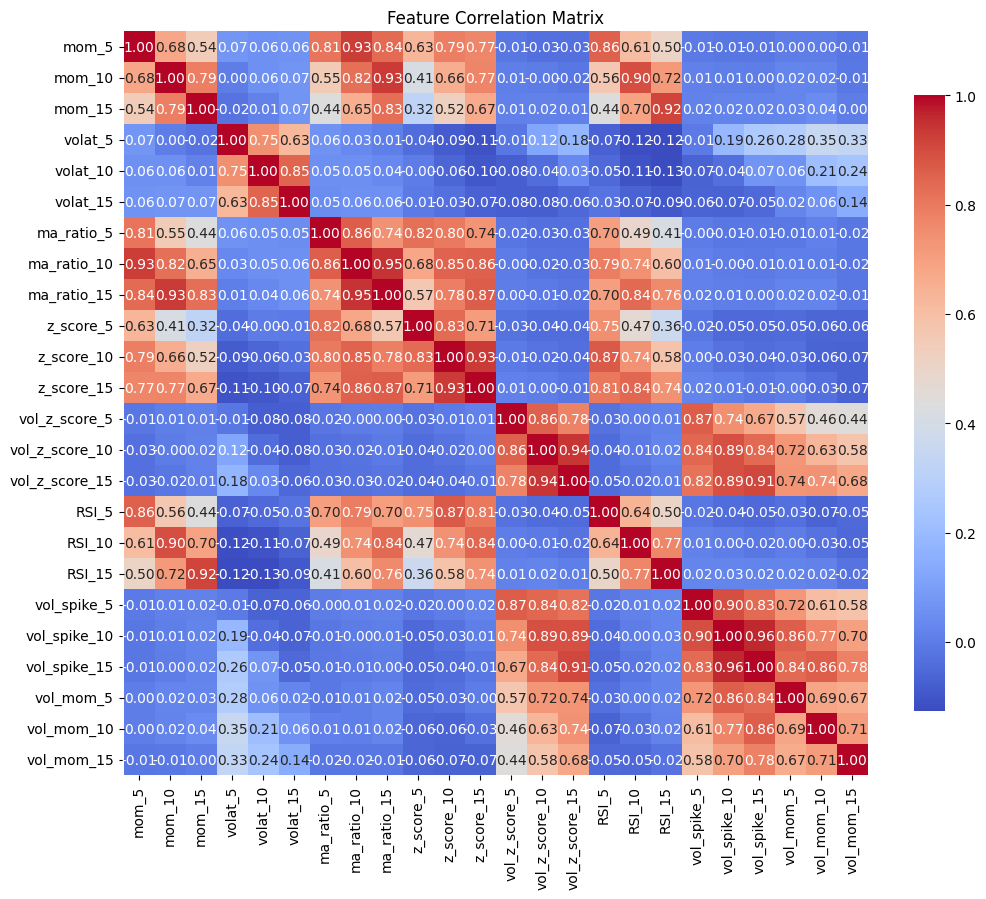

In [98]:
import seaborn as sns

X_corr = X_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(X_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.show()

In [114]:
def feat_select(corr_mat: pd.DataFrame, importances: pd.DataFrame, threshold: float = 0.85) -> list:
    """
    Select features based on permutation importance.
    Parameters
    ----------
    importances : pd.DataFrame
        DataFrame with 'feature', 'importance', and 'std' columns.
    threshold : float, default 0.85
    Returns
    -------
    selected_features : list
        List of selected feature names and dropout features.
    """
    features = importances.iloc[:,0]
    feat_set = set(features)

    while feat_set:
        feat = feat_set.pop()
        sieve = corr_mat[feat] > threshold # Booleans that correspond to features correlated with current feature 
        high_corr = corr_mat.index[sieve] # Highly correlated features
        high_corr_set = set(high_corr) # Set of highly correlated features
        high_corr_set.add(feat)


        print(importances[importances['feature'].isin(high_corr_set)])


feat_select(X_corr.abs(), perm_df, threshold=0.85)


       feature  importance       std
6   ma_ratio_5    0.013981  0.010728
7  ma_ratio_10    0.009277  0.007722
         feature  importance       std
22    vol_mom_10    0.020728  0.007315
20  vol_spike_15    0.008478  0.010431
   feature  importance       std
17  RSI_15    0.022503  0.013259
2   mom_15    0.011540  0.010632
           feature  importance       std
13  vol_z_score_10    0.045051  0.009810
18     vol_spike_5    0.005237  0.007405
12   vol_z_score_5    0.004350  0.003055
    feature  importance       std
4  volat_10     0.02166  0.012864
           feature  importance       std
22      vol_mom_10    0.020728  0.007315
20    vol_spike_15    0.008478  0.010431
14  vol_z_score_15    0.007501  0.009758
19    vol_spike_10    0.003684  0.004698
        feature  importance       std
8   ma_ratio_15    0.023657  0.012936
1        mom_10    0.014336  0.010578
16       RSI_10    0.005814  0.004580
     feature  importance       std
9  z_score_5    0.015313  0.012485
   feature  im